 # Code for the introductory example in paper 1.

In [1]:
import cuqi
from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian, LMRF, Gamma
from cuqi.problem import BayesianProblem
from cuqi.data import imresize, rgb2gray

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # for reproducibility
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.8.0.post0.dev13


Currently we load the cookie image and add it to the testproblem. `phantom="cookie"` is part of the upcoming release.

In [2]:
# Load cookie.png from current folder.
cookie = plt.imread('figs/cookie.png')

# Convert to rgb.
cookie = cookie[:, :, :3]

# Convert to grayscale.
cookie = rgb2gray(cookie)

# Resize to 256x256.
cookie = imresize(cookie, (256, 256))

# Make background completely black.
cookie[cookie < 0.05] = 0

In [3]:
A, y_data, info = Deconvolution2D(dim=256, phantom=cookie).get_components()

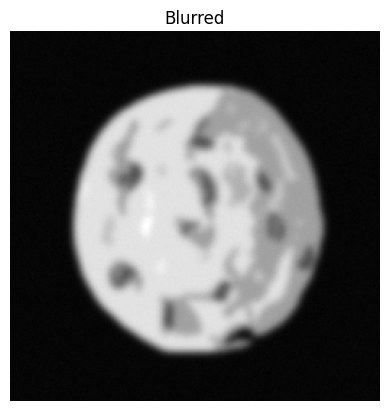

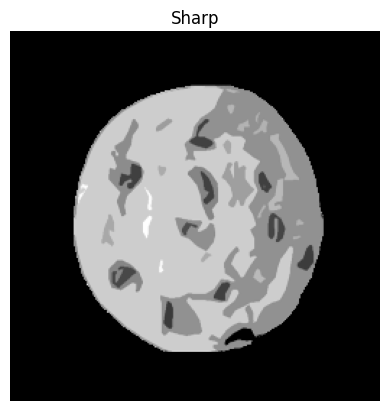

In [4]:
y_data.plot(); plt.axis('off'); plt.title('Blurred'); plt.show()
info.exactSolution.plot(); plt.axis('off'); plt.title('Sharp'); plt.show()

In [6]:
# Define Bayesian Problem. Note we use lambda functions here, but direct algebraic expressions are part of next release.
d = Gamma(1, 1e-4)
s = Gamma(1, 1e-4)
x = LMRF(0, lambda d: 1/d, geometry=A.domain_geometry)
y = Gaussian(A @ x, lambda s: 1/s)

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: UGLA
	d: ConjugateApprox
	s: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 1177.6972782611847
Plotting results


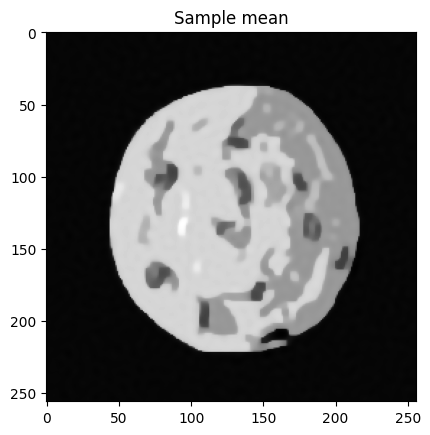

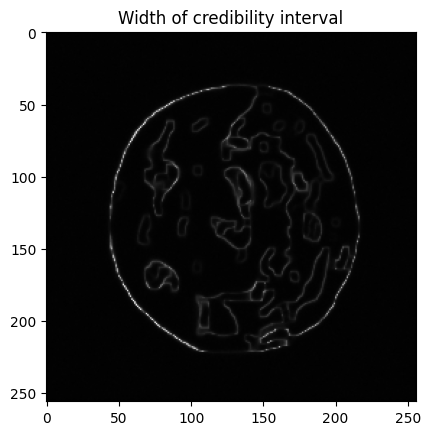

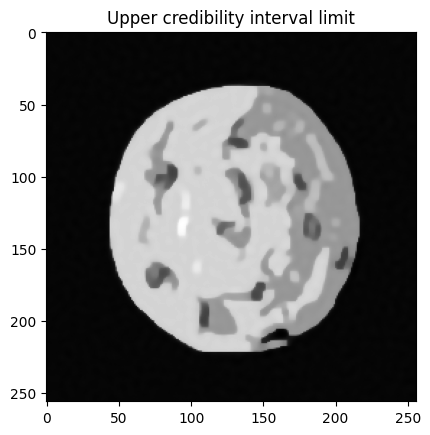

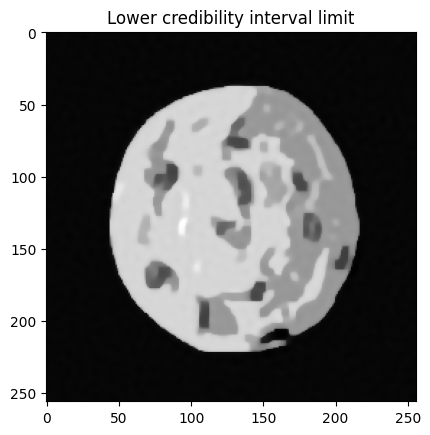

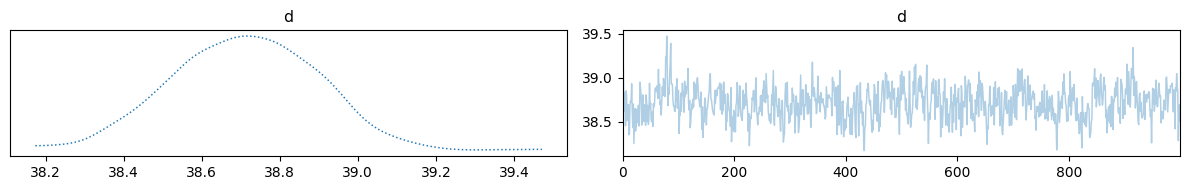

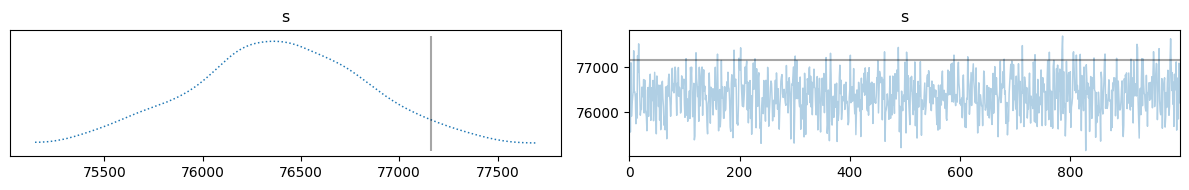

In [7]:
# Set data and do UQ.
BP = BayesianProblem(x, y, d, s)
BP.set_data(y=y_data)
samples = BP.UQ(1000, exact={"s": 1/(0.0036**2)})

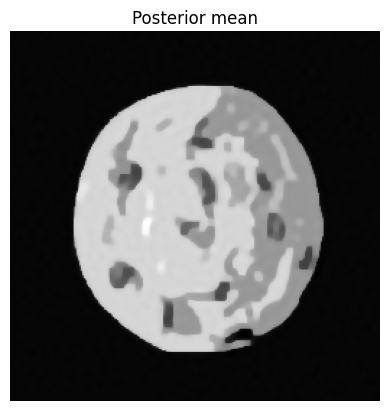

In [8]:
samples["x"].plot_mean(); plt.title('Posterior mean'); plt.axis('off'); plt.show()

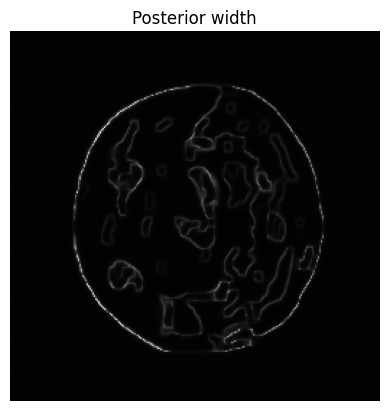

In [10]:
samples["x"].plot_ci_width(); plt.title('Posterior width'); plt.axis('off'); plt.show()

In [11]:
# Print nicely statistics of s and d. Only works if hyperparameters=True.
# We print the mean, lower and upper 99% confidence interval.
print(f"{'':<10} {'mean':<10} {'lower':<10} {'upper':<10} {'actual':<10}")
print(f"{'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")
for key in ["s", "d"]:
    mean = samples[key].mean()
    lower, upper = samples[key].compute_ci(99)
    if key == "s":
        actual = 1/(0.0036**2)
        print(f"{key:<10} {mean[0]:<10.3e} {lower[0]:<10.3e} {upper[0]:<10.3e} {actual:<10.3e}")
    else:
        print(f"{key:<10} {mean[0]:<10.3e} {lower[0]:<10.3e} {upper[0]:<10.3e} {'-':<10}")

           mean       lower      upper      actual    
---------- ---------- ---------- ---------- ----------
s          7.639e+04  7.535e+04  7.744e+04  7.716e+04 
d          3.871e+01  3.824e+01  3.918e+01  -         
